# Introduction

This notebook explores the keystroke dataset for the study titled __High-accuracy
detection of early Parkinson's Disease using multiple characteristics of finger
movement while typing__. The notebook goes through various data-cleaning
techniques to clean and consolidate the provided data files. A number of
observations and visualizations are also included.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

# Reading in data

The provided data files are divided into two sub-folders:
- Folder 1: `Archived users`, which contains information on the participants'
details (gender, year of diagnosis, whether the participant has tremors, etc.)
- Folder 2: `Tappy Data`, which contains keystroke statistics from specific
participants (hold time, current hand, previous hand, etc.)

Here we are getting a list of all the files present in the `Archived users`
folder. However, not all users in the above set have a corresponding typing
data in the `Tappy Data` folder. We therefore compute the intersection of these
two sets, i.e. the user IDs that both have a user data file in Folder 1, and a
typing data file in Folder 2.

In [2]:
user_file_list = os.listdir('../data/Archived users/')
user_set_v1 = set(map(lambda x: x[5: 15], user_file_list))  # [5: 15] to return just the user IDs


tappy_file_list = os.listdir('../data/Tappy Data/')
user_set_v2 = set(map(lambda x: x[: 10], tappy_file_list))  # [: 10] to return just the user IDs


user_set = user_set_v1.intersection(user_set_v2)

len(user_set)

217

In [3]:
def read_user_file(file_name):
    f = open('../data/Archived users/' + file_name)
    data = [line.split(': ')[1][: -1] for line in f.readlines()]
    f.close()

    return data

files = os.listdir('../data/Archived users/')

columns = [
    'BirthYear', 'Gender', 'Parkinsons', 'Tremors', 'DiagnosisYear',
    'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other'
]

user_df = pd.DataFrame(columns=columns) # empty Data Frame for now

for user_id in user_set:
    temp_file_name = 'User_' + user_id + '.txt' # tappy file names have the format of `User_[UserID].txt`
    if temp_file_name in files: # check to see if the user ID is in our valid user set
        temp_data = read_user_file(temp_file_name)
        user_df.loc[user_id] = temp_data # adding data to our DataFrame

user_df.head()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
S8Y5T8RWZ4,,Male,True,True,,Left,Don't know,Mild,False,False,False,True
WXNQ0QM0XD,1959,Female,False,False,------,None,Don't know,------,False,False,False,False
JMIVIRFQRR,1947,Male,True,True,2007,Right,3,Severe,True,True,False,False
R3OKI24Z0Q,1934,Female,True,True,2016,Left,Don't know,Mild,False,False,False,False
BZ8MQ2TBMS,,Female,True,False,2015,None,Don't know,Medium,True,False,True,True


# Data cleaning and preprocessing

Data in a number of columns needs to be processed, cleaned, or reformatted.
First, we are changing data in `BirthYear` and `DiagnosisYear` to a numeric
format, if a cell has an invalid data format, change it to `NaN`. (For example,
row 2, `DianosisYear` column above.)

In [4]:
# force some columns to have numeric data type
user_df['BirthYear'] = pd.to_numeric(user_df['BirthYear'], errors='coerce')
user_df['DiagnosisYear'] = pd.to_numeric(user_df['DiagnosisYear'], errors='coerce')

Encoding binary data: some columns have True-False data values, here we are
converting it to binary data (0s and 1s), for better data processing by machine
learning models.

In [5]:
user_df = user_df.rename(index=str, columns={'Gender': 'Female'})  # renaming `Gender` to `Female`
user_df['Female'] = user_df['Female'] == 'Female'  # change string data to boolean data
user_df['Female'] = user_df['Female'].astype(int)  # change boolean data to binary data

str_to_binary_columns = ['Parkinsons', 'Tremors', 'Levadopa', 'DA', 'MAOB', 'Other']  # columns to be converted to binary data

for column in str_to_binary_columns:
    user_df[column] = user_df[column] == 'True'
    user_df[column] = user_df[column].astype(int)

Dummy variables: some categorical data will now be converted to mutually
exclusive binary data through dummy variables (aka one-hot encoding).

In [6]:
# prior processing for `Impact` column
user_df.loc[
    (user_df['Impact'] != 'Medium') &
    (user_df['Impact'] != 'Mild') &
    (user_df['Impact'] != 'Severe'), 'Impact'] = 'None'


to_dummy_column_indices = ['Sided', 'UPDRS', 'Impact']  # columns to be one-hot encoded

for column in to_dummy_column_indices:
    user_df = pd.concat([
        user_df.iloc[:, : user_df.columns.get_loc(column)],
        pd.get_dummies(user_df[column], prefix=str(column)),
        user_df.iloc[:, user_df.columns.get_loc(column) + 1 :]
    ], axis=1)

user_df.head()

,BirthYear,Female,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,UPDRS_4,UPDRS_Don't know,Impact_Medium,Impact_Mild,Impact_None,Impact_Severe,Levadopa,DA,MAOB,Other
S8Y5T8RWZ4,NaN,0,1,1,NaN,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
WXNQ0QM0XD,1959.0,1,0,0,NaN,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
JMIVIRFQRR,1947.0,0,1,1,2007.0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
R3OKI24Z0Q,1934.0,1,1,1,2016.0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
BZ8MQ2TBMS,NaN,1,1,0,2015.0,0,1,0,0,0,...,0,1,1,0,0,0,1,0,1,1


# Visualization

Missing data count:

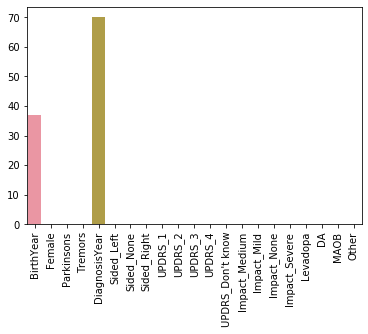

In [7]:
missing_data = user_df.isnull().sum()

g = sns.barplot(missing_data.index, missing_data)
g.set_xticklabels(labels=missing_data.index, rotation=90)

plt.show()

Birth year distribution, gender count, and tremor count:

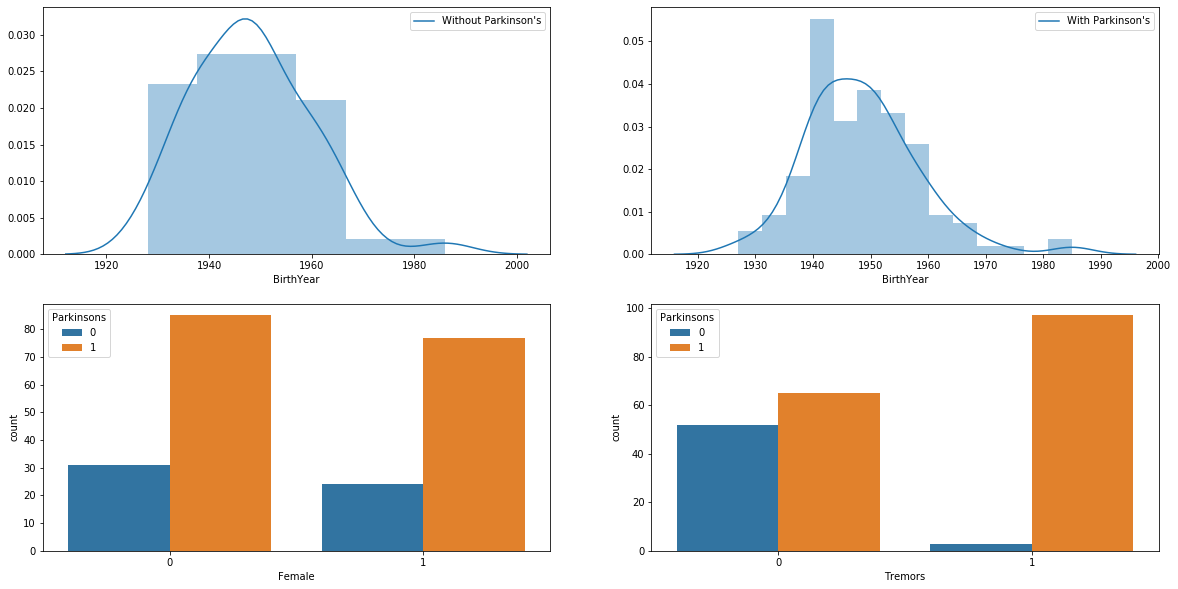

In [8]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))


sns.distplot(
    user_df.loc[user_df['Parkinsons'] == 0, 'BirthYear'].dropna(axis=0),
    kde_kws = {'label': "Without Parkinson's"},
    ax = ax[0][0]
)
sns.distplot(
    user_df.loc[user_df['Parkinsons'] == 1, 'BirthYear'].dropna(axis=0),
    kde_kws = {'label': "With Parkinson's"},
    ax = ax[0][1]
)

sns.countplot(x='Female', hue='Parkinsons', data=user_df, ax=ax[1][0])
sns.countplot(x='Tremors', hue='Parkinsons', data=user_df, ax=ax[1][1])

plt.show()

# Incorporating the second dataset

Here we will read in a file in our second folder and explore it. From that we
will consequently write a general function to process similar files later on.

(Note that the data in the `Hold time`, `Latency time`, and `Flight time`
columns are in milliseconds.)

In [9]:
file_name = '0EA27ICBLF_1607.txt'  # an arbitrary file to explore


df = pd.read_csv(
    '../data/Tappy Data/' + file_name,
    delimiter = '\t',
    index_col = False,
    names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time']
)

df = df.drop('UserKey', axis=1)

df.head()

/Users/quannguyen/PycharmProjects/PyCharmBook/Chapter13/PipelineV2/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Timestamp,Hand,Hold time,Direction,Latency time,Flight time
0,160722,18:41:04.336,L,0101.6,LL,0234.4,0156.3
1,160722,18:42:14.070,L,0085.9,LL,0437.5,0359.4
2,160722,18:42:14.273,L,0078.1,LL,0210.9,0125.0
3,160722,18:42:14.617,L,0062.5,LL,0359.4,0281.3
4,160722,18:42:15.586,S,0125.0,LS,0187.5,0093.8


Next we will be using the `pd.to_datetime()` and `pd.to_numeric()` functions to
force-convert our data to be stored in the correct data types.

In [10]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date
# converting time data to numeric
for column in ['Hold time', 'Latency time', 'Flight time']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df = df.dropna(axis=0)

df.head()

,Date,Timestamp,Hand,Hold time,Direction,Latency time,Flight time
0,2016-01-22,18:41:04.336,L,101.6,LL,234.4,156.3
1,2016-01-22,18:42:14.070,L,85.9,LL,437.5,359.4
2,2016-01-22,18:42:14.273,L,78.1,LL,210.9,125.0
3,2016-01-22,18:42:14.617,L,62.5,LL,359.4,281.3
4,2016-01-22,18:42:15.586,S,125.0,LS,187.5,93.8


Similarly, below we are dropping any entries that don't have the correct data
in the `Hand` and `Direction` columns.

In [11]:
# cleaning data in Hand
df = df[
    (df['Hand'] == 'L') |
    (df['Hand'] == 'R') |
    (df['Hand'] == 'S')
]

# cleaning data in Direction
df = df[
    (df['Direction'] == 'LL') |
    (df['Direction'] == 'LR') |
    (df['Direction'] == 'LS') |
    (df['Direction'] == 'RL') |
    (df['Direction'] == 'RR') |
    (df['Direction'] == 'RS') |
    (df['Direction'] == 'SL') |
    (df['Direction'] == 'SR') |
    (df['Direction'] == 'SS')
]

df.head()

,Date,Timestamp,Hand,Hold time,Direction,Latency time,Flight time
0,2016-01-22,18:41:04.336,L,101.6,LL,234.4,156.3
1,2016-01-22,18:42:14.070,L,85.9,LL,437.5,359.4
2,2016-01-22,18:42:14.273,L,78.1,LL,210.9,125.0
3,2016-01-22,18:42:14.617,L,62.5,LL,359.4,281.3
4,2016-01-22,18:42:15.586,S,125.0,LS,187.5,93.8


For our purposes, we will only be looking at the mean (average) time of the
`Hold time`, `Latency time`, and `Flight time` columns in groups of the same
`Direction` data. In other words, we will split our current Pandas dataframe
into groups of `LL` direction, of `LS` direction, of `LR` direction, and so on.
(`L` denotes left hand, `R` denotes right hand, and `S` denotes the spacebar).

This calculation could be achived easily by the function `groupby()`:

In [12]:
direction_group_df = df.groupby('Direction').mean()
direction_group_df

,Hold time,Latency time,Flight time
Direction,,,
LL,81.897585,263.693681,184.458003
LR,81.563368,277.280266,210.061092
LS,113.614473,204.752122,121.226882
RL,74.481909,417.072856,340.956823
RR,79.109145,275.253268,205.742761
RS,115.448340,233.403863,150.378538
SL,69.692995,346.412846,233.743770
SR,75.492281,345.973700,235.207990
SS,84.336522,141.706087,73.095217


Recall that this is simply a summary of keystroke data of a specific user at a
specific time period. For the sake of convenience, we will put all the commands
above into a function to process this data. Note that the function will return
the data in an ordered NumPy array for the sake of runtime.

In [13]:
def read_tappy(file_name):
    df = pd.read_csv(
        '../data/Tappy Data/' + file_name,
        delimiter = '\t',
        index_col = False,
        names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time',
                 'Direction', 'Latency time', 'Flight time']
    )

    df = df.drop('UserKey', axis=1)

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date

    # Convert time data to numeric
    for column in ['Hold time', 'Latency time', 'Flight time']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(axis=0)

    # Clean data in `Hand`
    df = df[
        (df['Hand'] == 'L') |
        (df['Hand'] == 'R') |
        (df['Hand'] == 'S')
    ]

    # Clean data in `Direction`
    df = df[
        (df['Direction'] == 'LL') |
        (df['Direction'] == 'LR') |
        (df['Direction'] == 'LS') |
        (df['Direction'] == 'RL') |
        (df['Direction'] == 'RR') |
        (df['Direction'] == 'RS') |
        (df['Direction'] == 'SL') |
        (df['Direction'] == 'SR') |
        (df['Direction'] == 'SS')
    ]

    direction_group_df = df.groupby('Direction').mean()
    del df; gc.collect()
    
    direction_group_df = direction_group_df.reindex(
        ['LL', 'LR', 'LS', 'RL', 'RR', 'RS', 'SL', 'SR', 'SS'])
    direction_group_df = direction_group_df.sort_index()  # to ensure correct order of data
    
    return direction_group_df.values.flatten()  # returning a numppy array

Since a user can have multiple typing data files ranging multiple months (for
example, `0EA27ICBLF` has `0EA27ICBLF_1607.txt` and `0EA27ICBLF_1608.txt`), we
are now writing a function that takes in a user ID, searches for all typing
data files for that user, and returns the mean of corresponding `Direction` and
`Time` data.

In [14]:
def process_user(user_id, filenames):
    running_user_data = np.array([])

    for filename in filenames:
        if user_id in filename:
            running_user_data = np.append(running_user_data, read_tappy(filename))
    
    running_user_data = np.reshape(running_user_data, (-1, 27))  # flatten time data
    
    return np.nanmean(running_user_data, axis=0)  # ignoring NaNs while calculating the mean

Next, we will loop through all user IDs we have in our `user_df` DataFrame,
calling our `process_user()` function and creating a new DataFrame in the process.

In [15]:
filenames = os.listdir('../data/Tappy Data/')

column_names = [first_hand + second_hand + '_' + time 
                for first_hand in ['L', 'R', 'S'] 
                for second_hand in ['L', 'R', 'S'] 
                for time in ['Hold time', 'Latency time', 'Flight time']]

user_tappy_df = pd.DataFrame(columns=column_names)

for user_id in user_df.index:
    user_tappy_data = process_user(str(user_id), filenames)
    user_tappy_df.loc[user_id] = user_tappy_data

# Some preliminary data cleaning
user_tappy_df = user_tappy_df.fillna(0)
user_tappy_df[user_tappy_df < 0] = 0    

user_tappy_df.head()

/Users/quannguyen/PycharmProjects/PyCharmBook/Chapter13/PipelineV2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/quannguyen/PycharmProjects/PyCharmBook/Chapter13/PipelineV2/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/quannguyen/PycharmProjects/PyCharmBook/Chapter13/PipelineV2/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/quannguyen/PycharmProjects/PyCharmBook/Chapter13/PipelineV2/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,4) have mixed types. Specify dtype o

,LL_Hold time,LL_Latency time,LL_Flight time,LR_Hold time,LR_Latency time,LR_Flight time,LS_Hold time,LS_Latency time,LS_Flight time,RL_Hold time,...,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
S8Y5T8RWZ4,172.636000,297.744000,211.126000,209.685417,343.756250,154.098958,228.896154,311.526923,123.125000,197.662857,...,180.628571,186.045833,316.416667,206.887500,141.530769,430.600000,231.676923,188.800000,335.966667,125.000000
WXNQ0QM0XD,97.954754,263.886551,213.640841,251.493544,258.072294,178.211188,93.627843,194.920319,115.430495,88.930406,...,140.727149,89.273028,360.027778,313.559347,80.055791,407.583022,379.169815,87.175035,303.556651,225.451756
JMIVIRFQRR,209.645892,192.881814,194.354431,91.332338,154.879528,124.534628,115.458170,267.182715,208.730735,100.026454,...,221.440556,144.631592,244.940379,206.417440,169.969553,256.374137,203.306182,122.424698,255.756830,152.889163
R3OKI24Z0Q,152.116511,519.229799,382.892599,126.228382,535.526531,390.329552,177.828571,562.981349,417.413889,138.460381,...,347.455556,140.830556,702.155556,563.613889,152.983333,578.116667,419.950000,0.000000,0.000000,0.000000
BZ8MQ2TBMS,98.176760,235.310731,178.433493,80.943020,173.236327,161.293143,95.376904,195.119289,136.070051,101.347415,...,161.976860,87.798384,254.043134,225.529725,80.397681,209.750725,202.293043,78.766667,299.483333,192.700000


Here we are concatenating the `user_df` DataFrame, which contains information
on the users (year of birth, year of diagnosis, drug use, etc.), and the
`user_tappy_df` DataFrame, which contains typing data for corresponding users.

In [16]:
combined_user_df = pd.concat([user_df, user_tappy_df], axis=1)
combined_user_df.to_csv('../data/combined_user.csv')

combined_user_df.head()

,BirthYear,Female,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
S8Y5T8RWZ4,NaN,0,1,1,NaN,1,0,0,0,0,...,180.628571,186.045833,316.416667,206.887500,141.530769,430.600000,231.676923,188.800000,335.966667,125.000000
WXNQ0QM0XD,1959.0,1,0,0,NaN,0,1,0,0,0,...,140.727149,89.273028,360.027778,313.559347,80.055791,407.583022,379.169815,87.175035,303.556651,225.451756
JMIVIRFQRR,1947.0,0,1,1,2007.0,0,0,1,0,0,...,221.440556,144.631592,244.940379,206.417440,169.969553,256.374137,203.306182,122.424698,255.756830,152.889163
R3OKI24Z0Q,1934.0,1,1,1,2016.0,1,0,0,0,0,...,347.455556,140.830556,702.155556,563.613889,152.983333,578.116667,419.950000,0.000000,0.000000,0.000000
BZ8MQ2TBMS,NaN,1,1,0,2015.0,0,1,0,0,0,...,161.976860,87.798384,254.043134,225.529725,80.397681,209.750725,202.293043,78.766667,299.483333,192.700000


# Visualization

We will use boxplots to visualize distributions of different time data (hold
time, latency time, and flight time) between participants with and without
Parkinsons's. Each subplot will contain data in a specific typing switch
type--for example, the top left subplot contains typing data when participants
go from a left-hand key to another left-hand key (denoted as `LL` above the
subplot), while the top right one contains data when participants switch from a
left-hand key to a space (`LS`).

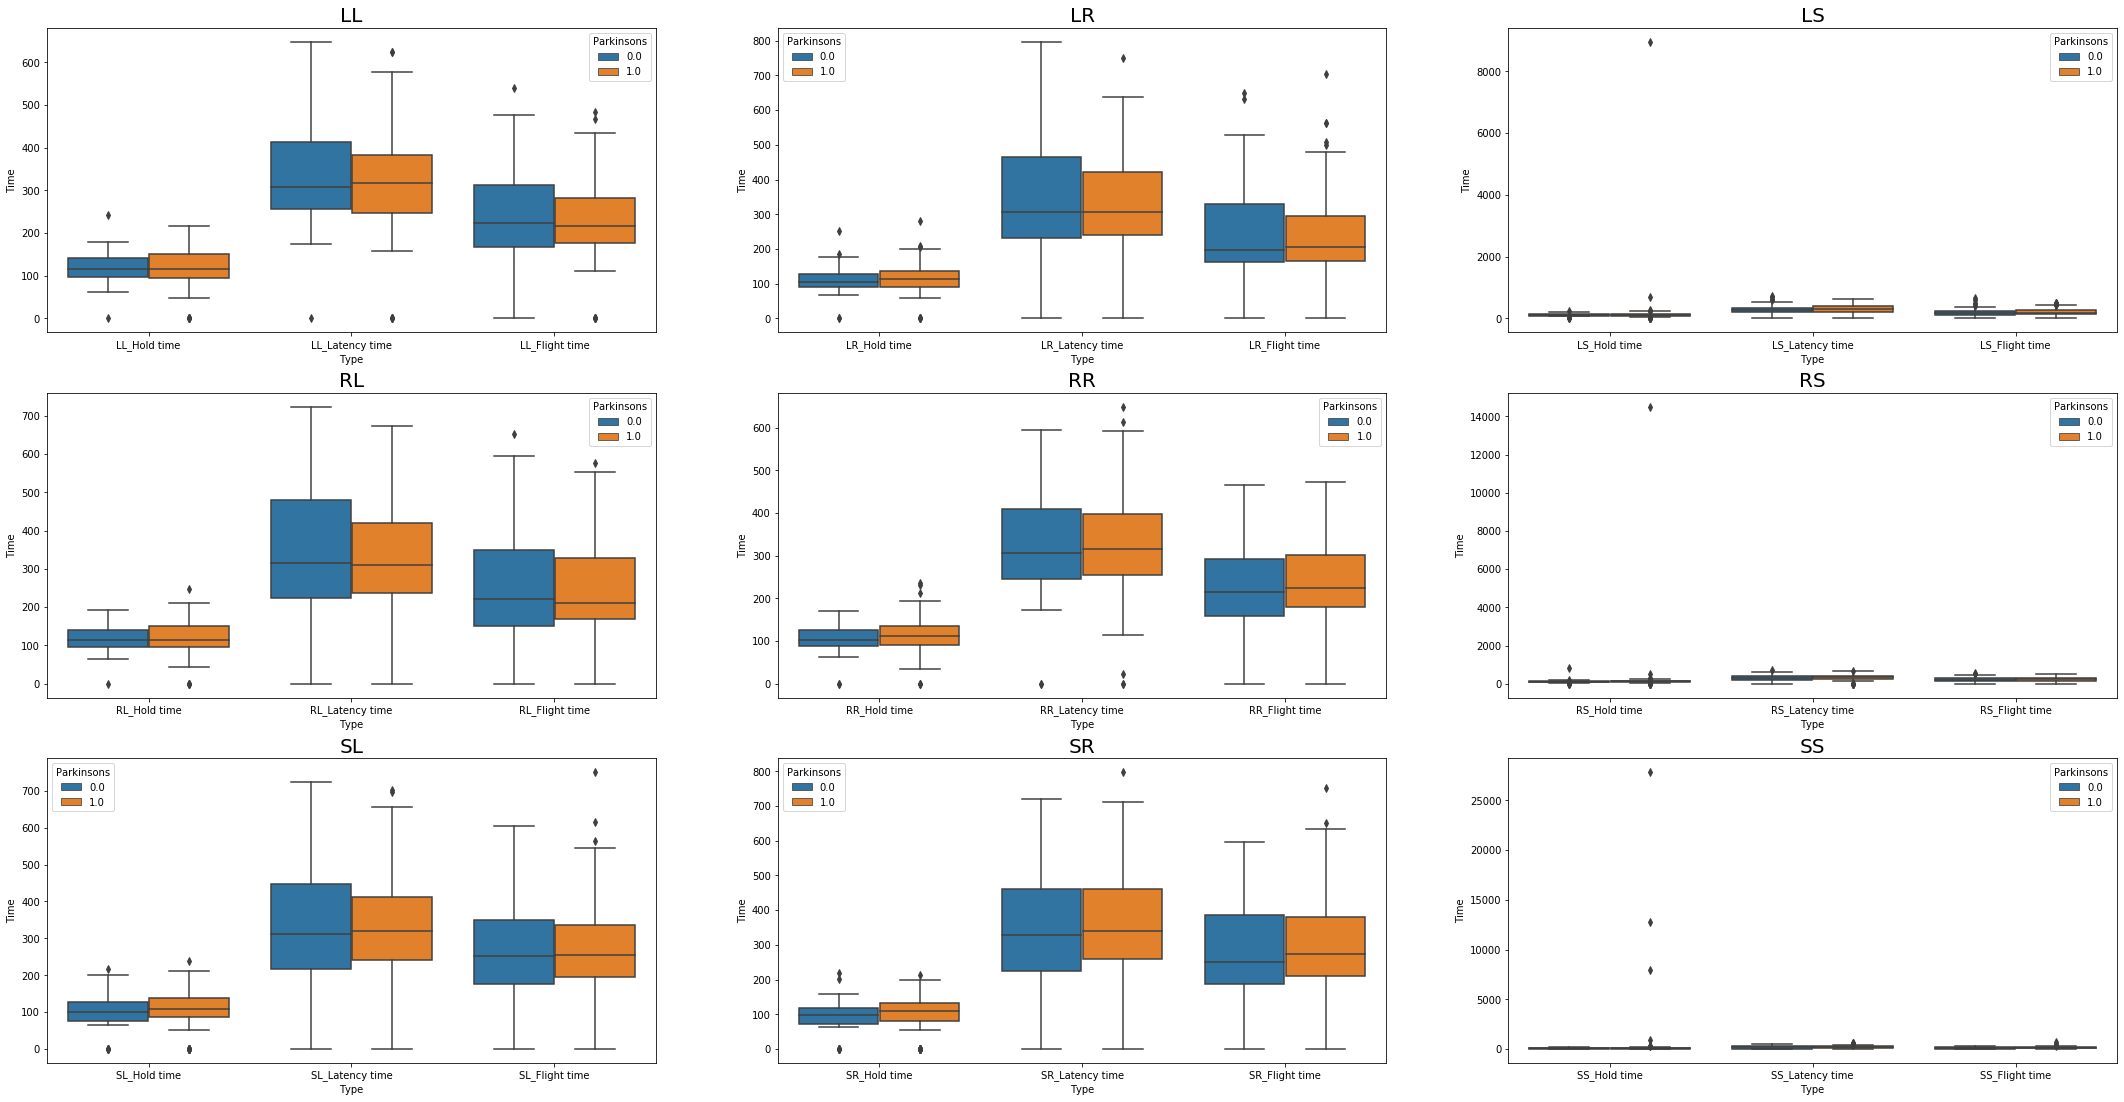

In [17]:
f, ax = plt.subplots(3, 3, figsize=(10, 5))

plt.subplots_adjust(
    right = 3,
    top = 3
)

for i in range(9):
    temp_columns = column_names[3 * i : 3 * i + 3]
    stacked_df = combined_user_df[temp_columns].stack().reset_index()
    
    stacked_df = stacked_df.rename(
        columns={'level_0': 'index', 'level_1': 'Type', 0: 'Time'})
    stacked_df = stacked_df.set_index('index')

    for index in stacked_df.index:
        stacked_df.loc[index, 'Parkinsons'] = combined_user_df.loc[index, 'Parkinsons']
    
    sns.boxplot(x='Type', y='Time',
                hue='Parkinsons',
                data=stacked_df,
                ax=ax[i // 3][i % 3]
                ).set_title(column_names[i * 3][: 2], fontsize=20)
    
plt.show()
